In [197]:
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
import itertools
from itertools import combinations_with_replacement
from itertools import combinations
from itertools import permutations

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

log_plot = True

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later

criteria_dict = {"cs_name_val" : 12}
project = signac.get_project("GPBO_Fix")
save_csv = False
save_figs = False
analyzer = General_Analysis(criteria_dict, project, mode = "act", save_csv = save_csv)
plotters = Plotters(analyzer, save_figs)

def grid_sampling(num_points, bounds):
        """
        Generates Grid sampled data
        
        Parameters
        ----------
        num_points: int, number of points in LHS, should be greater than # of dimensions
        bounds: ndarray, array containing upper and lower bounds of elements in LHS sample. Defaults of 0 and 1
        
        Returns:
        ----------
        grid_data: ndarray, (num_points)**bounds.shape[1] grid sample of data
        
        """
        #Generate mesh_grid data for theta_set in 2D
        #Define linspace for theta
        params = np.linspace(0,1, num_points)
        #Define dimensions of parameter
        dimensions = bounds.shape[1]
        #Generate the equivalent of all meshgrid points
        df = pd.DataFrame(list(itertools.product(params, repeat=dimensions)))
        df2 = df.drop_duplicates()
        scaled_data = df2.to_numpy()
        #Normalize to bounds 
        lower_bound = bounds[0]
        upper_bound = bounds[1]
        grid_data = scaled_data*(upper_bound - lower_bound) + lower_bound 
        return grid_data

#Create a function to define the SSE for any Theta vector on a heat map.
def sse_func(xx, yy, x, y, args):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all Theta1 values
            
        yy: An D X N array of all Theta2 values
        theta: parameter vector
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    sse = np.zeros([len(xx),len(yy)])
    
    for i in range(len(xx)):
        for j in range(len(yy)):
            theta = np.array([xx[i][j],yy[i][j]])
            sse[i][j] = sum((y - uniquac_model(theta,x, args))**2) 
    
    return sse

# Create a function to optimize, in this case, least squares fitting
def regression_func(theta_guess, x, y, args=None):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        theta_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    
    error = y - calc_mm_model(theta_guess,x, args); #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

def calc_gamma_exp(Xexp, P, y1, theta_ref, args):
    # Extract parameters
    r = np.array(args["r"])
    q = np.array(args["q"])
    z = args.get("z", 10)
    R = args["R"]
    T = args["T"]
    A, B, C = np.array(args["A"]), np.array(args["B"]), np.array(args["C"])
    
    l = (z / 2) * (r - q) - (r - 1)
    tau = np.exp(-theta_ref / (R * T))
    psat = 10 ** (A - (B / (C + (T - 273.15))))
    term1 = np.log(r[0]/r[1])
    term2a = 5*np.log((q[0]*r[1])/(q[1]*r[0])) - np.log(tau[1]) + 1 -tau[0]
    term2 = q[0]*term2a
    term3 = l[0]-(r[0]/r[1])*l[1]
    gamma_inf1 = np.exp(term1 + term2 + term3)

    term1_x2 = np.log(r[1]/r[0])
    term2a_x2 = 5*np.log((q[1]*r[0])/(q[0]*r[1])) - np.log(tau[0]) + 1 -tau[1]
    term2_x2 = q[1]*term2a_x2
    term3_x2 = l[1]-(r[1]/r[0])*l[0]
    gamma_inf2 = np.exp(term1_x2 + term2_x2 + term3_x2)
    gamma = []
    for i in range(len(Xexp)):
        if Xexp[i] == 0:
            gamma.append(gamma_inf1)
        elif Xexp[i] == 1:
            gamma.append(gamma_inf2)
        else:
            value = P[i]*y1[i]/(psat[0]*Xexp[i])
            gamma.append(value)
    return np.array(gamma) #Gamma1
#gamma[~valid_mask[0,0], 0] = gamma_inf[0]  # Where x1 = 0
def uniquac_model(unknown_params, xP, args):
    """
    Compute activity coefficients using the UNIQUAC model for a binary mixture.

    Parameters:
    unknown_params : np.array
        A vector containing the unknown interaction energy parameters Δu_ij.
    xP : np.array or float
        Mole fractions x1 (x2 is inferred).
    args : dict
        A dictionary containing necessary additional parameters:
        - "r": np.array, volume parameters for components
        - "q": np.array, surface area parameters for components
        - "R": float, gas constant
        - "T": float, temperature
        - "z": float, coordination number (default 10)
        - "A", "B", "C": Antoine equation parameters for vapor pressure

    Returns:
    np.array or float
        Vapor pressure P.
    """
    # Extract parameters
    r = np.array(args["r"])
    q = np.array(args["q"])
    z = args.get("z", 10)
    R = args["R"]
    T = args["T"]
    A, B, C = np.array(args["A"]), np.array(args["B"]), np.array(args["C"])
    mode = args["mode"]
    
    # Precompute constants
    l = (z / 2) * (r - q) - (r - 1)
    tau = np.exp(-unknown_params / (R * T))
    psat = 10 ** (A - B / (C + (T - 273.15)))

    # Ensure xP is at least 1D
    x1 = np.atleast_2d(xP).reshape(-1,1)
    x2 = 1 - x1
    x = np.hstack([x1, x2])

    # Initialize gamma with ones
    gamma = np.ones_like(x, dtype=float)

    # Identify valid indices where both x1 and x2 are nonzero
    valid_mask = (x1.flatten() > 0) & (x2.flatten() > 0)

    if np.any(valid_mask):
        # Apply valid_mask correctly to both dimensions
        valid_x = x[valid_mask, :]  # Shape (M, 2) where M is number of valid rows

        sum_xq = np.dot(valid_x, q)
        sum_xr = np.dot(valid_x, r)

        theta = (valid_x * q) / sum_xq[:, None]
        psi = (valid_x * r) / sum_xr[:, None]

        lngC = (
            np.log(psi / valid_x) + (z / 2) * q * np.log(theta / psi) + psi[:, ::-1] * (l - r * l[::-1] / r[::-1])
        )

        lngR = (
            -q * np.log(theta + theta[:, ::-1] * tau[::-1]) + theta[:, ::-1] * q * (
                tau[::-1] / (theta + theta[:, ::-1] * tau[::-1]) - tau / (theta[:, ::-1] + theta * tau)
            )
        )

        gamma[valid_mask, :] = np.exp(lngC + lngR)
        
    # Handle infinite dilution cases
    if np.any(~valid_mask):
        # Compute gamma at infinite dilution for both components
        gamma_inf = np.zeros(2)

        # term1 = 1- (r[0]/r[1]) +np.log(r[0]/r[1])
        # term2 = -5*q[0]*(1-(r[0]*q[1])/(r[1]*q[0]) + np.log((r[0]*q[1])/(r[1]*q[0])))

        term1 = np.log(r[0]/r[1])
        term2a = 5*np.log((q[0]*r[1])/(q[1]*r[0])) - np.log(tau[1]) + 1 -tau[0]
        term2 = q[0]*term2a
        term3 = l[0]-(r[0]/r[1])*l[1]
        gamma_inf[0] = np.exp(term1 + term2 + term3)

        term1_x2 = np.log(r[1]/r[0])
        term2a_x2 = 5*np.log((q[1]*r[0])/(q[0]*r[1])) - np.log(tau[0]) + 1 -tau[1]
        term2_x2 = q[1]*term2a_x2
        term3_x2 = l[1]-(r[1]/r[0])*l[0]
        gamma_inf[1] = np.exp(term1_x2 + term2_x2 + term3_x2)

    gamma1 = gamma[:, 0]
    gamma2 = gamma[:, 1]

    #Manually alter gamma values at infinite dilution
    if np.any(x2.flatten() == 0):
        gamma2[-1] = gamma_inf[1]
    if np.any(x1.flatten() == 0):
        gamma1[0] = gamma_inf[0]
        

    P = np.sum(x * gamma * psat, axis=1)
    if mode == "P":
        var = P # Return scalar if input was scalar-like
    else:
        var = gamma1

    return var[0] if var.shape == (1,) else var 
    
def calc_mm_model(model_coefficients, x, args = None):
    """
    Caclulates the Muller Potential
    
    Parameters
    ----------
        model_coefficients: ndarray, The array containing the values of Muller constants
        x: ndarray, Values of X
        noise: ndarray, Any noise associated with the model calculation
    
    Returns:
    --------
        y_mul: float, value of Muller potential
    """    
    theta = model_coefficients
    # y_mul = (theta[0] * x**3 - theta[1] * x**2 + 2*x - 1)**2 + (theta[0] - theta[1])**2 + (x**2 - 1)**2 #MC Example
    # y_mul = theta[0]*(1 - theta[1]*np.exp(-theta[2]*x)) #Choline Chloride
    # y_mul = -(theta[3]+theta[4])*np.exp(-theta[0]*x) + theta[3]*np.exp(-theta[1]*x) + theta[4]*np.exp(-theta[2]*x) #Ethyl Acrylate
    # y_mul = (theta[0]*(x-theta[1])*(1-np.exp(theta[2]*(x-theta[3]))))**2 #Ratkowsky Model
    # y_mul = theta[0]*(1-((x-theta[1])**2/((x-theta[1])**2+x*(theta[3]+theta[2]-x)-(theta[2]*theta[3])))) #Cardinal Temperature Model
    # y_mul = theta[0]+1/(x - theta[1]) #Rod and Hancil Nonlinear Fit
    # y_mul = theta[0]*((x**2 + theta[1]*x)/(x**2+theta[2]*x + theta[3])) #Kowalik Problem
    # y_mul = theta[0] + (0.49-theta[0])*(np.exp(-theta[1]*(x-8))) #Model C (Bates and Watts)
    # y_mul = theta[0]*np.exp(-np.exp(theta[1]-theta[2]*x)) #Model G (Bates and Watts)
    # y_mul = theta[0]*(1-theta[1]*np.exp(-theta[2]*x)) #Model I (Bates and Watts)
    # y_mul = (theta[1]*theta[2]+theta[0]*x**theta[3])/(theta[2]+x**theta[3]) #Model O (Bates and Watts)
    # y_mul = theta[0]*np.exp(-theta[3]*x) + theta[1]*np.exp(-theta[4]*x) + theta[2]*np.exp(-theta[5]*x) #Pharmacokinetic model
    y_mul = np.exp(theta[0]-theta[3]*x) + np.exp(theta[1]-theta[4]*x) - np.exp(theta[2]-theta[5]*x) #Pharmacokinetic model
    # y_mul = uniquac_model(theta, x, args)
    return y_mul
argsvals = None

In [198]:
#Choline Chloride (ILL POSED)
# param_name_str = "t1t2t3"
# indeces_to_consider = [0,1,2]
# bounds_x = np.array([[3], [8]])
# bounds_theta_l = [35.0,0.4, 0.01]
# bounds_theta_u = [45.0, 1.0, 0.5]
# theta_ref = np.array([39.09, 0.828, 0.159]) 
# theta_names = ['theta_1', 'theta_2', 'theta_3']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#Ethyl Acrylate (ILL POSED + Only 1 Min)
# param_name_str = "t1t2t3t4t5"
# indeces_to_consider = [0,1,2,3,4]
# bounds_x = np.array([[0], [4]])
# bounds_theta_l = [1,0.1,0.01, 0.1, 0.001]
# bounds_theta_u = [10, 1, 0.1, 1, 0.01]
# theta_ref = np.array([3.025, 0.481, 0.0258, 0.310, 0.0011]) 
# theta_names = ['theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#MC Example (Well Posed, 2 min)
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[-2], [1.5]])
# bounds_theta_l = [-2,-2]
# bounds_theta_u = [2,2]
# theta_ref = np.array([-1.5, 0.5 ]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#The Ratkowsky Model (Ill posed, 2 min) (see Set-membership nonlinear regression approach to parameter estimation)
# D. Ratkowsky, R. Lowry, T. McMeekin, A. Stokes, R. Chandler, A model for
#bacterial culture growth rate throughout the entire biokinetic temperature
#range, J. Bacteriol. 154 (1983) 1222–1226.)
# param_name_str = "t1t2t3t4"
# indeces_to_consider = [0,1,2,3]
# bounds_x = np.array([[294], [320]])
# bounds_theta_l = [0,245,0,310]
# bounds_theta_u = [0.1,290,1,325]
# theta_ref = np.array([0.0325, 273.54, 0.336, 321.37]) 
# theta_names = ["b", "Tmin", "c", "Tmax"]
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#cardinal temperature model (Well posed, 2 local min)
#] J. Lobry, L. Rosso, J. Flandrois, A fortran subroutine for the determination of
#parameter confidence limits in non-linear models, Binary 3 (1991) 86–93.
#In 5 restarts, 1 global min found (correct), 0 local min found
# param_name_str = "t1t2t3t4"
# indeces_to_consider = [0,1,2,3]
# bounds_x = np.array([[294], [320]])
# bounds_theta_l = [1.0,308,280,319]
# bounds_theta_u = [2.0,318,296,325]
# theta_ref = np.array([1.396, 313.25, 289.40, 320.23]) 
# theta_names = ["mu_opt", "Topt", "Tmin", "Tmax"]
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#Rod and Hancil Nonlinear Fit (Well posed, 2 min)
#Rod, V.; Hancil, V. Iterative Estimation of Model Parameters when Measurements of 
# #All Variables are Subject to Error. Comput. Chem. Eng. 1980, 4, 33.
#When 5 restarts, 1 global min found (correct), 0 local min found
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [5]])
# bounds_theta_l = [1.0,1.0]
# bounds_theta_u = [10,10]
# theta_ref = np.array([2.00,6.00]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#Kowalik Problem (see Global Optimization in Parameter Estimation of Nonlinear
#Algebraic Models via the Error-in-Variables Approach) (Ill posed, 2 local min)
#Moore, R., Hansen, E., & Leclerc, A. (1992). Rigorous Methods for Global Optimization. 
# #In C. A. Floudas & P. M. Pardalos (Eds.), Recent Advances in Global Optimization (pp. 321–342). 
# #Princeton University Press. http://www.jstor.org/stable/j.ctt7ztwft.19
# param_name_str = "t1t2t3t4"
# indeces_to_consider = [0,1,2,3]
# bounds_x = np.array([[1/4], [2.50]])
# bounds_theta_l = [0,-0.2892, -0.2892,-0.2892]
# bounds_theta_u = [0.2892,0.2892, 0.35,0.2892]
# theta_ref = np.array([0.19283, 0.19088, 0.12314, 0.13578]) 
# theta_names = ['theta_1', 'theta_2', 'theta_3', 'theta_4']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#Model C (Bates and Watts) (Well posed, 1 min)
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[8], [42]])
# bounds_theta_l = [0.380,0.075]
# bounds_theta_u = [0.400, 0.128]
# theta_ref = np.array([0.3901,0.1016]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#Gompertz Model (Bates and Watts Model H) (Ill posed, 1 min)
# param_name_str = "t1t2t3"
# indeces_to_consider = [0,1,2]
# bounds_x = np.array([[118], [1582]])
# bounds_theta_l = [130, 1, 0.001]
# bounds_theta_u = [200, 5, 0.003]
# theta_ref = np.array([172, 2.18,0.0016]) 
# theta_names = ['theta_1', 'theta_2', 'theta_3']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#Bates and Watts Model I (Ill Posed 1 min)
# param_name_str = "t1t2t3"
# indeces_to_consider = [0,1,2]
# bounds_x = np.array([[118], [1582]])
# bounds_theta_l = [450, 0.1, 10**-4]
# bounds_theta_u = [500, 0.5, 5*10**-4]
# theta_ref = np.array([478, 0.357, 2.64*10**-4]) 
# theta_names = ['theta_1', 'theta_2', 'theta_3']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#Bates and Watts Model O (see 10.1063/1.4940872) (Well posed, 1 local min)
# param_name_str = "t1t2t3t4"
# indeces_to_consider = [0,1,2,3]
# bounds_x = np.array([[0], [10]])
# bounds_theta_l = [0.5, 1,1,1]
# bounds_theta_u = [2, 15, 10,5]
# theta_ref = np.array([1, 12.371, 6.318,3.46]) 
# theta_names = ['theta_1', 'theta_2', 'theta_3', 'theta_4']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#Pharmacokinetic model (2 min, sse successul most often (w/ Xexp and std = 0.005))
# William R. Esposito, Christodoulos A. Floudas, Parameter estimation in nonlinear algebraic models via global optimization, 
# Computers & Chemical Engineering, Volume 22, Supplement 1, 1998, Pages S213-S220, ISSN 0098-1354, https://doi.org/10.1016/S0098-1354(98)00217-8. (Well posed, 2 local min)
# param_name_str = "t1t2t3t4t5t6"
# indeces_to_consider = [0,1,2,3,4,5]
# bounds_x = np.array([[4], [120]])
# bounds_theta_l = [-2.302, 1e-4,1e-4,1e-4,1e-4,1e-4 ]
# bounds_theta_u = [1e-4, 2.302, 2.302, 0.5,0.5,0.5]
# theta_ref = np.array([-1.0345, 0.6966, 1.5200, 0.01491, 0.1102, 0.2847]) 
# Xexp = np.array([4,8,12,23,45,75,95,120])
# theta_names = ['theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )

#VLE Methanol + Water (DECHEMA 50C)
#w/ Exp Data 1 local min
#w/ Xexp + Ysim sdt=0.01*mean 1 min
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e3,-1e3 ]
# bounds_theta_u = [1e3,1e3]
# theta_ref = np.array([349.2925, -246.6378]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# P = np.array([92.50,143.00,196.50, 244.50,286.00,333.00,373.00,406.00])
# y1 = np.array([0.0, 0.3783,0.5883,0.7076, 0.7807,0.8655,0.9349,1.000])
# Xexp = np.array([0.0,0.0873,0.1900,0.3417,0.4943,0.6919,0.8492,1.000])
# argsvals = {"r" :[1.4311,0.92], #MeOH, H2O
#         "q" :[1.432,1.4],
#         "T" : 50+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [8.08097,8.07131],
#         "B": [1582.271,1730.63],
#         "C": [239.726,233.426],
#         "mode": "gamma"
#         } 
# Yexp_org = calc_gamma_exp(Xexp, P, y1, theta_ref, argsvals)

#VLE Methanol + Water (DECHEMA 100 C pg 73) (https://www.sciencedirect.com/science/article/pii/S0098135419311214)
#Exp data = 1 incorrect global min
#Xexp + Yexp +std=0.01*mean 1 global min;
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e4,-1e4 ]
# bounds_theta_u = [1e4,1e4]
# theta_ref = np.array([-540.3161, 935.0742]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# P = np.array([782.80,828.40,927.2,1003.2,1071.6,1238.8,1322.4,1535.2,1626.4,1884.8,2029.2,2112.8,2340.8,2508.0,2530.8,2530.8])
# Xexp = np.array([0.0022,0.011,0.035,0.053,0.074,0.121,0.163,0.281,0.352,0.522,0.606,0.667,0.826,0.9360,0.946,0.958])
# y1 = np.array([0.0192,0.086,0.191,0.245,0.313,0.434,0.496,0.619,0.662,0.75,0.792,0.824,0.911,0.969,0.976,0.981])
# argsvals = {"r" :[1.4311,0.92], #MeOH, H2O
#         "q" :[1.432,1.4],
#         "T" : 100+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [7.97007,8.01767],
#         "B": [1521.23,1715.7],
#         "C": [233.97,234.268],
#         "mode": "gamma"
#         } 
# Yexp_org = calc_gamma_exp(Xexp, P, y1, theta_ref, argsvals)


#VLE DMSO + EG
#w/ Exp Data, 2 min; in 5 no mins found, in 10 2 global, 1 local w/ data)
#w/ Yexp sim and stdev=0.01*mean,3 min; in 5 restarts 1 global (incorrect), 0 local min
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-2e3,-2e3 ]
# bounds_theta_u = [2e3,2e3]
# theta_ref = np.array([757.6653, -759.0704]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# Xexp = np.array([0,.149,.2100,.283,.4010,.5050,.5970,.7060,.7910,.899,1])
# # Yexp_org = np.array([15.80, 16.30,16.80,17.70,17.80,19.60,22.40,27.10,29.80,34.40,38.80])
# argsvals = {"r" :[2.8266, 2.4088], #DMSO, EG
#         "q" :[2.4720, 2.2480],
#         "T" : 373.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [6.88076,8.09083],
#         "B": [1541.520,2088.936],
#         "C": [191.797,203.454],
#         "mode": "P"
#         } 

#VLE Methanol + Water (https://www.degruyter.com/document/doi/10.1515/zpch-1927-13002/html / DECHEMA)
#2 local min, in 5, 4 global, 1 local w/ real data 
# 0 global, 5 local w/ grid and stdev=0.01*mean

# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e3,-1e3 ] #Use 1e-4 w/ real data
# bounds_theta_u = [1e3,1e3]
# theta_ref = np.array([-99.5814, 99.4288]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# # P = np.array([119.50, 157.00, 169.70, 196.00, 217.70, 236.60, 
# #                    283.00, 306.40, 324.10, 348.40, 373.50, 391.10])
# # y1 = np.array([0.2741, 0.4741, 0.5220, 0.6294, 0.7106, 0.7580, 
# #                0.8203, 0.8654, 0.9007, 0.9406, 0.9627, 0.9736])
# # Xexp = np.array([0.0486, 0.1218, 0.1478, 0.2131, 0.2693, 0.3252, 
# #                0.5143, 0.6279, 0.7083, 0.8037, 0.9007, 0.9461])
# argsvals = {"r" :[1.4311,0.92], #MeOH, H2O
#         "q" :[1.432,1.4],
#         "T" : 49.76+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [8.08097,8.07131],
#         "B": [1582.271,1730.63],
#         "C": [239.726,233.426],
#         "mode": "gamma"
#         } 
# Yexp_org = calc_gamma_exp(Xexp, P, y1, theta_ref, argsvals)


#VLE Methanol + Water (DECHEMA 25C pg 44) (2 local min, neither correct)
#5 restarts finds 1 global (incorrect) min w/ exp data
# w/ Xexp and created Yexp only 1 solution
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e3,-1e3 ]
# bounds_theta_u = [1e3,1e3]
# theta_ref = np.array([397.2158, -285.2931]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# # P = np.array([23.70,37.5,53.0,69.8,82.3,98.5,112.0,124.0])
# # y1 = np.array([0.0, 0.4187,0.6187,0.7350,0.7934,0.8822,0.9384,1.000])
# Xexp = np.array([0.0,0.0873,0.1900,0.3417,0.4943,0.6919,0.8492,1.000])
# argsvals = {"r" :[1.4311,0.92], #MeOH, H2O
#         "q" :[1.432,1.4],
#         "T" : 25+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [8.08097,8.07131],
#         "B": [1582.271,1730.63],
#         "C": [239.726,233.426],
#         "mode": "gamma"
#         } 
# Yexp_org = calc_gamma_exp(Xexp, P, y1, theta_ref, argsvals)

#VLE Methanol + Water (https://www.degruyter.com/document/doi/10.1515/zpch-1927-13002/html / DECHEMA)
#w/ Exp Data 2 local min; in 5, 4 global, 1 local 
#w/ Xexp + Ysim std=0.01*mean 2 min, but true not a solution; 2 local min found (3,2 ratio of each)
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e3,-1e3 ] #Use 1e-4 w/ real data
# bounds_theta_u = [1e3,1e3]
# theta_ref = np.array([-99.5814, 99.4288]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# # P = np.array([119.50, 157.00, 169.70, 196.00, 217.70, 236.60, 
# #                    283.00, 306.40, 324.10, 348.40, 373.50, 391.10])
# # y1 = np.array([0.2741, 0.4741, 0.5220, 0.6294, 0.7106, 0.7580, 
# #                0.8203, 0.8654, 0.9007, 0.9406, 0.9627, 0.9736])
# Xexp = np.array([0.0486, 0.1218, 0.1478, 0.2131, 0.2693, 0.3252, 
#                0.5143, 0.6279, 0.7083, 0.8037, 0.9007, 0.9461])
# argsvals = {"r" :[1.4311,0.92], #MeOH, H2O
#         "q" :[1.432,1.4],
#         "T" : 49.76+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [8.08097,8.07131],
#         "B": [1582.271,1730.63],
#         "C": [239.726,233.426],
#         "mode": "gamma"
#         } 
# Yexp_org = calc_gamma_exp(Xexp, P, y1, theta_ref, argsvals)

#VLE ACN + Water (DECHEMA 75 C pg 83)
#w/ Exp data, 9 local min (true sln not found)
#W/ Xexp + Ysim std=0.01*mean 11 min (true solution found); 5 restarts only true soln found
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e4,-1e4 ]
# bounds_theta_u = [1e4,1e4]
# theta_ref = np.array([379.1786,320.9444]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# P = np.array([80.0,101.0,115.0,119.0,120.0,119.40,119.0])
# Xexp = np.array([0.03,0.07,0.17,0.44,0.65,0.87,0.92])
# y1 = np.array([0.63,0.72,0.77,0.797,0.80,0.83,0.87])
# argsvals = {"r" :[1.8701,0.92], #ACN, H2O
#         "q" :[1.7240,1.4],
#         "T" : 30+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [7.33986,8.07131],
#         "B": [1482.29,1730.63],
#         "C": [250.523,233.426],
#         "mode": "gamma"
#         } 
# Yexp_org = calc_gamma_exp(Xexp, P, y1, theta_ref, argsvals)

#VLE DMSO + EG
#w/ Exp Data, 2 min; in 5 no mins found, in 10 2 global, 1 local w/ data)
#w/ Yexp sim and stdev=0.01*mean,3 min; in 5 restarts 1 global (incorrect) x5, 0 local min
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-2e3,-2e3 ]
# bounds_theta_u = [2e3,2e3]
# theta_ref = np.array([757.6653, -759.0704]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# Xexp = np.array([0,.149,.2100,.283,.4010,.5050,.5970,.7060,.7910,.899,1])
# Yexp_org = np.array([15.80, 16.30,16.80,17.70,17.80,19.60,22.40,27.10,29.80,34.40,38.80])
# argsvals = {"r" :[2.8266, 2.4088], #DMSO, EG
#         "q" :[2.4720, 2.2480],
#         "T" : 373.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [6.88076,8.09083],
#         "B": [1541.520,2088.936],
#         "C": [191.797,203.454],
#         "mode": "P"
#         } 

#VLE Methanol + Water (DECHEMA 25C pg 42)
#Exp data 2 (incorrect) global min
# Xexp + Ysim std=0.01*mean 3 min (1 true + 2 local); 5 local min (2/3)
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e3,-1e3 ]
# bounds_theta_u = [1e3,1e3]
# theta_ref = np.array([419.5912, -350.4400]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# P = np.array([26.70,30.00,34.00,36.30,42.60,55.30,75.40,96.20,109.90,126.60])
# Xexp = np.array([0.0202,0.0403,0.0620,0.0791,0.1145,0.2017,0.3973,0.6579,0.8137,1.000])
# y1 = np.array([0.1441,0.2557,0.3463,0.4160,0.5047,0.6474,0.7904,0.8908,0.9521,1.000])
# argsvals = {"r" :[1.4311,0.92], #MeOH, H2O
#         "q" :[1.432,1.4],
#         "T" : 25+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [8.08097,8.07131],
#         "B": [1582.271,1730.63],
#         "C": [239.726,233.426],
#         "mode": "gamma"
#         } 
# Yexp_org = calc_gamma_exp(Xexp, P, y1, theta_ref, argsvals)

#VLE Methanol + Water (DECHEMA 25C pg 42) (2 min, neither correct)
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e3,-1e3 ]
# bounds_theta_u = [1e3,1e3]
# theta_ref = np.array([419.5912, -350.4400]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# P = np.array([26.70,30.00,34.00,36.30,42.60,55.30,75.40,96.20,109.90,126.60])
# Xexp = np.array([0.0202,0.0403,0.0620,0.0791,0.1145,0.2017,0.3973,0.6579,0.8137,1.000])
# y1 = np.array([0.1441,0.2557,0.3463,0.4160,0.5047,0.6474,0.7904,0.8908,0.9521,1.000])
# argsvals = {"r" :[1.4311,0.92], #MeOH, H2O
#         "q" :[1.432,1.4],
#         "T" : 25+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [8.08097,8.07131],
#         "B": [1582.271,1730.63],
#         "C": [239.726,233.426],
#         "mode": "gamma"
#         } 
# Yexp_org = calc_gamma_exp(Xexp, P, y1, theta_ref, argsvals)

#VLE Methanol + Water (DECHEMA 60C pg 41)
#Exp data 1 correct global min
# Xexp + Ysim std=0.01*mean 1 true min
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e3,-1e3 ]
# bounds_theta_u = [1e3,1e3]
# theta_ref = np.array([230.8789, -153.8262]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# P = np.array([183.64,196.92,211.65,228.70,254.75,291.74,309.50,353.18,395.79,431.10,466.95,538.25])
# Xexp = np.array([0.0343,0.0446,0.0594,0.0793,0.1092,0.1634,0.1961,0.2705,0.3670,0.4619, 0.5665, 0.7582])
# y1 = np.array([0.2106, 0.2699,0.3312,0.3920,0.4714,0.5698,0.5989,0.6699,0.7462,0.7889,0.8223,0.9010])
# argsvals = {"r" :[1.4311,0.92], #MeOH, H2O
#         "q" :[1.432,1.4],
#         "T" : 60+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [8.08097,8.07131],
#         "B": [1582.271,1730.63],
#         "C": [239.726,233.426],
#         "mode": "gamma"
#         } 
# Yexp_org = calc_gamma_exp(Xexp, P, y1, theta_ref, argsvals)

#VLE THF + Water (DECHEMA Vol 1pt1 pg 371)
#Exp data 1 global minima (not true value)
#With Yexp data 1 (not true minima)
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e3,-1e3 ]
# bounds_theta_u = [1e3,1e3]
# theta_ref = np.array([1079.1760,-131.3244]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# P = np.array([123.8,133.6,140.2,146.0,151.4,156.4,161.4,166.2,170.8,174.0,171.0])
# Xexp = np.array([0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95])
# y1 = np.array([0.8091,0.8260,0.8342,0.8430,0.8520,0.8635,0.8735,0.8838,0.8960,0.9118,0.9310])
# argsvals = {"r" :[2.9415,0.92], #THF, H2O
#         "q" :[2.7200,1.4],
#         "T" : 25+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [6.99515,8.07131],
#         "B": [1202.290,1730.63],
#         "C": [226.254,233.426],
#         "mode": "gamma"
#         } 
# Yexp_org = calc_gamma_exp(Xexp, P, y1, theta_ref, argsvals)

#VLE EG + Water (DECHEMA 1C pg 2)
#Exp Data 2 local min (neither true)
# Xexp Data + Ysim (std = 0.01*mean) 2 min (neither true) 935/65
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e3,-1e3]
# bounds_theta_u = [1e3,1e3]
# theta_ref = np.array([-232.6924,-2.1708]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# P = np.array([31.88,39.9,71.78,102.68,252.17,398.73,494.44,513.34,531.27,608.08,680.83,695.76])
# Xexp = np.array([0.0260,0.0390,0.0890,0.1370,0.3770,0.5940,0.71,0.733,0.754,0.841,0.912,0.97])
# y1 = np.array([0.57,0.68,0.826,0.879,0.964,0.986,0.992,0.995,0.994,0.997,0.998,0.999])
# argsvals = {"r" :[0.92, 2.4088], #H2O, EG
#         "q" :[1.4, 2.2480],
#         "T" : 98.0+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [8.07131, 7.76432],
#         "B": [1730.63, 1851.880],
#         "C": [233.426, 181.744],
#         "mode": "y"
#         } 
# Yexp_org = y1

#VLE Water + Glycerol (DECHEMA 1B pg 183)
#Exp data 2 local min, neither is true solution
#Xexp Data + Ysim (std = 0.01*mean) 3 min 824("true")  14   3
# param_name_str = "t1t2"
# indeces_to_consider = [0,1]
# bounds_x = np.array([[0], [1]])
# bounds_theta_l = [-1e3,-1e3 ]
# bounds_theta_u = [1e3,1e3]
# theta_ref = np.array([267.9504,-542.5218]) 
# theta_names = ['theta_1', 'theta_2']
# theta_true = np.array([theta_ref[i] for i in indeces_to_consider] )
# theta_true_names = np.array([theta_names[i] for i in indeces_to_consider] )
# P = np.array([35.5,36.0,39.0,46.5,59.3,70.0,74.2,85.3,92.5])
# Xexp = np.array([0.4567,0.4884,0.5132,0.5839,0.7030,0.8033,0.8512,0.9686,1.00])
# argsvals = {"r" :[0.92, 3.5857], #H2O + Glycerol
#         "q" :[1.4, 3.06],
#         "T" : 50+273.15, #K
#         "R" : 1.98721 , #cal/molK
#         "A": [8.07225,6.95133],
#         "B": [1730.63, 1541.52],
#         "C": [233.426, 191.797],
#         "mode": "P"
#         }
# Yexp_org = P

restarts = 5

[0.16228145 0.67775625 0.68190454 0.40481007 0.19576658 0.11668078
 0.08626865 0.05938943]
0.0029810722048988327


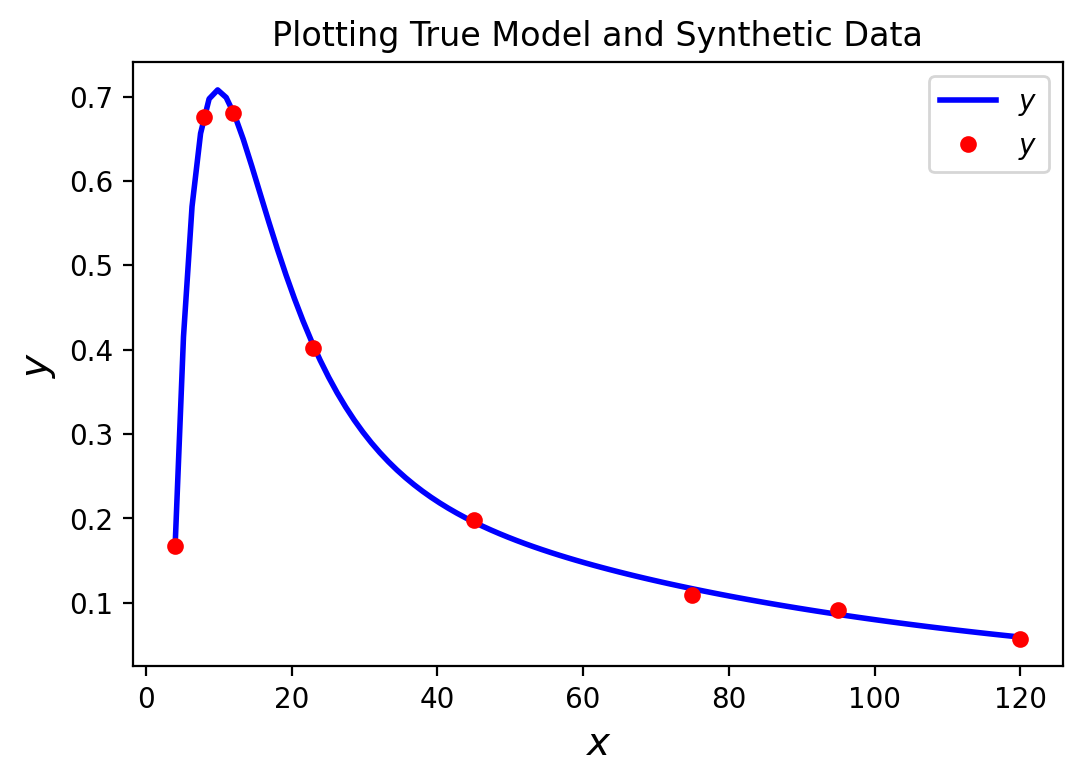

In [199]:
num_params = len(theta_ref)
np.random.seed(1)
# Evaluate model and add noise based on assumed theta values
# This generates experimental data points (If you don't want to define them above)
# num_points = 8 #len(Xexp)
# Xexp = grid_sampling(num_points, bounds_x)
Yexp_org = np.array([ calc_mm_model(theta_ref, Xexp[i], argsvals)  for i in range(len(Xexp)) ]).flatten()
print(Yexp_org)
std = abs(np.mean(Yexp_org))*0.01
print(std)
noise = np.random.normal(size=len(Yexp_org), loc = 0, scale = std)
Yexp = Yexp_org + noise

# Evaluate model based on the assumed experimental values
X = np.linspace(np.min(Xexp),np.max(Xexp),100).reshape(-1,1)
Y = calc_mm_model(theta_ref, X.reshape(-1,1),argsvals)
# Compare the experiments to the true model
plt.plot(X,Y,'b-',linewidth=2,label=r"$y$")
plt.plot(Xexp,Yexp,'r.',markersize=10,label=r"$y$")
plt.title("Plotting True Model and Synthetic Data")
plt.xlabel(r"$x$",fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
plt.legend()
plt.show()

In [200]:
##New Cell

## define function that includes nonlinear model
def model(theta_guess, theta_ref, x, indeces_to_consider, args=None):
    '''
        """
    Creates Muller potential values given a guess for "a"
    Parameters
    ----------
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, Independent variable data (exp or pred)
    Returns
    -------
        y_model: ndarray, The simulated Muller potential given the guess
    '''
    #Define an array to store y values in
    y_data = []
    #Loop over all theta values
    for i in range(len(x)):
        #Create model coefficient from true space substituting in the values of param_space at the correct indeces
        model_coefficients = theta_ref.copy()
        #Replace coefficients a specified indeces with their theta_val counterparts
        model_coefficients[indeces_to_consider] = theta_guess              
        #Create y data coefficients
        y = calc_mm_model(model_coefficients, x[i], args)
        y_data.append(y)
        # print(model_coefficients, x[i], y)

    #Convert list to array and flatten array
    y_model = np.array(y_data).flatten()
    
    return y_model

X_pred = np.linspace(np.min(Xexp),np.max(Xexp),100).reshape(-1,1)
print(model(theta_true, theta_true, Xexp, indeces_to_consider,argsvals))

##New Cell

# Create a function to optimize, in this case, least squares fitting
def regression_func(theta_guess, theta_ref, x, indeces_to_consider, y, args=None):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    error = y - model(theta_guess, theta_ref, x, indeces_to_consider, args) #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

print(regression_func(theta_true, theta_true, Xexp, indeces_to_consider, Yexp, argsvals))

#Create a function to define the SSE for any Theta vector on a heat map.
def sse_func(theta_guesses, theta_ref, indeces_to_consider, Xexp, Yexp, args):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all a_1 values
        yy: An D X N array of all a_2 values
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    #Initialize sse grid
    sse = np.zeros(len(theta_guesses))
    
    #For each guess
    for i in range(len(theta_guesses)):
        #Evaluate the model
        y_sim = model(theta_guesses[i], theta_ref, Xexp, indeces_to_consider, args)
        #Calculate SSE
        sse[i] = np.sum((y_sim - Yexp)**2)
     
    sse = sse.reshape(int(np.sqrt(len(theta_guesses))), -1).T
    
    return sse

print(sse_func([theta_true], theta_true, indeces_to_consider, Xexp, Yexp, argsvals))

[0.16228145 0.67775625 0.68190454 0.40481007 0.19576658 0.11668078
 0.08626865 0.05938943]
[ 0.00484229 -0.00182369 -0.00157452 -0.0031986   0.00257984 -0.00686105
  0.00520141 -0.00226921]
[[0.00012542]]


In [201]:
#New Cell
# Create synthetic data assuming the following values for theta
Theta_Guess = np.array([1,1])

# print(calc_cs1_polynomial(Theta_Guess,Xexp))
## specify initial guess
sse_list = []
opt_list = []
theta_list = []

## specify bounds
lower = np.array([bounds_theta_l[i] for i in indeces_to_consider] )
upper = np.array([bounds_theta_u[i] for i in indeces_to_consider] )
bounds = (lower, upper)

for i in range(restarts):
    theta_guess = np.random.uniform(low=lower, high=upper, size=len(lower) )
    # print(theta_guess)
    Solution = optimize.least_squares(regression_func, theta_guess, bounds=bounds, method='trf',
                                        args=(theta_true, Xexp.reshape(-1,1), indeces_to_consider, Yexp, argsvals),verbose=0)

    theta = Solution.x
    sse_list.append(Solution.cost)
    theta_list.append(theta)
    opt_list.append(Solution.optimality)
    # print("theta = ",theta)

all_sets = pd.DataFrame({'Theta': theta_list, 'SSE': sse_list, 'Optimality': opt_list})

# print(all_sets)
#Organize all_sets by SSE, lowest to highest
all_sets = all_sets.sort_values(by="SSE", ascending=True)

# # Drop duplicate minima
all_sets = all_sets.drop_duplicates(
    subset="SSE", keep="first")
# # Drop minima with optimality > 1e-4
all_sets = all_sets[all_sets["Optimality"] < 1e-4]

print(len(all_sets))

5


In [202]:
print(all_sets)

                                               Theta       SSE    Optimality
4  [-1.0049637173131447, 0.7627986960262901, 1.53...  0.000044  3.216064e-09
2  [-1.0049630304132664, 0.7628007121538014, 1.53...  0.000044  1.060510e-09
3  [-1.0049625471740797, 0.7628020930331206, 1.53...  0.000044  2.330489e-09
0  [9.999999999982272e-05, 0.00010000000000000002...  0.004445  2.724560e-08
1  [9.999999260160081e-05, 0.00010000000000074263...  0.004445  4.096296e-07


In [203]:
#Scale values between 0 and 1 with minmax scaler
scaler = MinMaxScaler()
scaler.fit([bounds_theta_l, bounds_theta_u])
all_param_sets = np.array(list(map(np.array, all_sets["Theta"].values)))
all_param_sets_scaled = scaler.transform(all_param_sets)
#Calculate the scaled euclidean distance between each pair of scaled points
dist = pdist(all_param_sets_scaled)/np.sqrt(all_param_sets.shape[1])
#Convert the condensed distance matrix to square form
dist_sq = squareform(dist)

#Initialize a boolean array to keep track of unique sets
unique_mask = np.ones(all_param_sets.shape[0], dtype=bool)
duplicate_counts = np.zeros(all_param_sets.shape[0], dtype=int)

# Iterate over the upper triangle of the distance matrix
for i in range(all_param_sets.shape[0]):
    # If the current set is already marked as non-unique, skip it
    if not unique_mask[i]:
        continue
    # Mark sets within the threshold distance as non-unique
    within_threshold = dist_sq[i] <= 0.01
    duplicate_counts[i] = np.sum(within_threshold)
    unique_mask[within_threshold] = False
    unique_mask[i] = True  # Keep the current set

# Filter out the unique sets from the pandas df
local_min_sets = all_sets[unique_mask]
local_min_counts = duplicate_counts[unique_mask]

print("Num local min count", local_min_counts)

print("Num local min", len(local_min_sets))
print(local_min_sets)

# print(all_sets)print("Best Theta = ", nlr_theta)
try:
    nlr_theta = local_min_sets.iloc[0]['Theta']
except:
    nlr_theta = local_min_sets.iloc[0]['Theta']
nlr_thetas = np.vstack(local_min_sets['Theta'])

print("Best Theta = ", nlr_theta)
print("theta_ref", theta_true)
Y_nlr_exp = model(nlr_theta, theta_true, Xexp, indeces_to_consider, argsvals)
error = (Yexp - Y_nlr_exp)
print("SSE = ", np.sum(error**2))

Num local min count [3 2]
Num local min 2
                                               Theta       SSE    Optimality
4  [-1.0049637173131447, 0.7627986960262901, 1.53...  0.000044  3.216064e-09
0  [9.999999999982272e-05, 0.00010000000000000002...  0.004445  2.724560e-08
Best Theta =  [-1.00496372  0.7627987   1.53947989  0.0153192   0.11483378  0.27826497]
theta_ref [-1.0345   0.6966   1.52     0.01491  0.1102   0.2847 ]
SSE =  8.802934857168978e-05


In [183]:
#Create heat map data
#Create list of heat map theta data
heat_map_data_dict = {}

#Create a linspace for the number of dimensions and define number of points
dim_theta = num_params
dim_list = np.linspace(0, dim_theta-1, dim_theta)

#Create a list of all combinations (without repeats e.g no (1,1), (2,2)) of dimensions of theta
mesh_combos = np.array(list(combinations(dim_list, 2)), dtype = int)
n_points = 20

#Meshgrid set always defined by n_points**2
theta_set = np.tile(np.array(theta_ref), (n_points**2, 1))

#Set x_vals
norm_x_vals = Xexp.reshape(-1,1)

#Loop over all possible theta combinations of 2
for i in range(len(mesh_combos)):
    #Create a copy of the true values to change the mehsgrid valus on
    theta_set_copy = np.copy(theta_set)
    #Set the indeces of theta_set for evaluation as each row of mesh_combos
    idcs = mesh_combos[i]
    #define name of parameter set as tuple ("param_1,param_2")
    data_set_name = (theta_true_names[idcs[0]], theta_true_names[idcs[1]])

    #Create a meshgrid of values of the 2 selected values of theta and reshape to the correct shape
    #Assume that theta1 and theta2 have equal number of points on the meshgrid
    theta1 = np.linspace(lower[idcs[0]], upper[idcs[0]], n_points)
    theta2 = np.linspace(lower[idcs[1]], upper[idcs[1]], n_points)
    theta12_mesh = np.array(np.meshgrid(theta1, theta2))
    theta12_vals = np.array(theta12_mesh).T.reshape(-1,2)

    #Set initial values for evaluation (true values) to meshgrid values
    theta_set_copy[:,idcs] = theta12_vals
    
    #Append data set to dictionary with name
    heat_map_data_dict[data_set_name] = theta_set_copy
    
hm_data_keys = list(heat_map_data_dict.keys())

In [184]:
print(nlr_thetas)

[[  501.08688056  -657.94608826]
 [ 1014.66204076  -843.74886816]
 [-1030.88106447  2000.        ]]


/scratch365/mcarlozo/Toy_Problem/bo_methods_lib/bo_methods_lib/GPBO_Classes_plotters.py:2205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


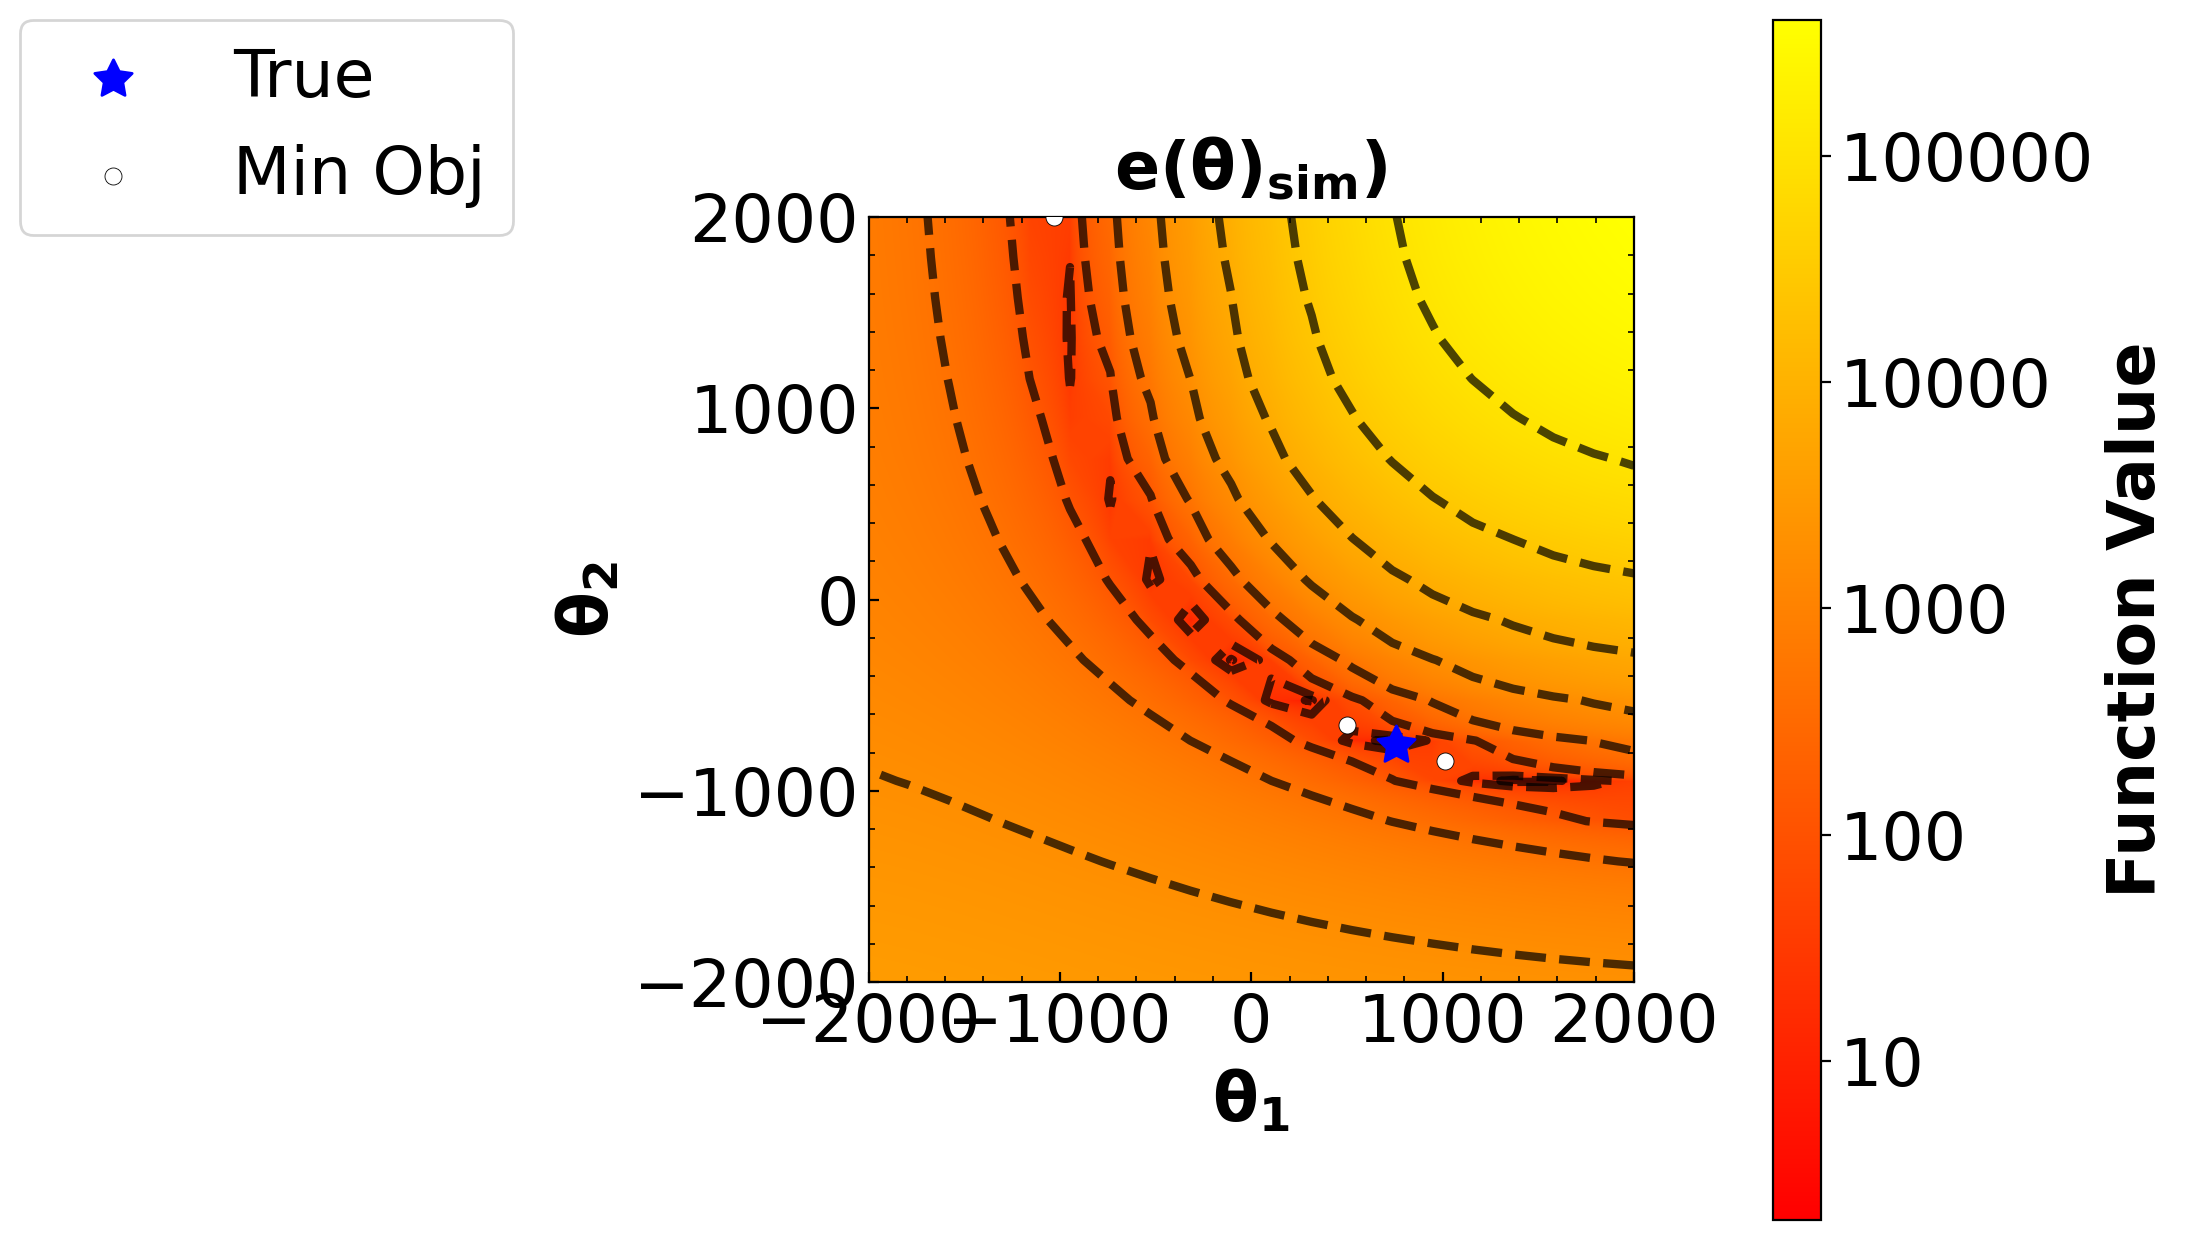

In [185]:
#New Cell
log_data = False
# save_figure = True
save_figure = False

#Get Number of pairs
combos = list(combinations(dim_list, 2))
pairs = len((list(combinations(dim_list, 2))))

#For each pair
for pair in range(pairs):
    #Make a meshgrid for each parameter
    idcs_to_plot = [int(combos[pair][i]) for i in range(len(combos[pair]))]
    theta_data = heat_map_data_dict[hm_data_keys[pair]].reshape(n_points, n_points, -1).T
    theta_mesh = np.take(theta_data, list(combos[pair]), axis=0)
    
    sse_sim = sse_func(heat_map_data_dict[hm_data_keys[pair]], theta_ref, indeces_to_consider, Xexp.reshape(-1,1), Yexp, argsvals)
    param_names = theta_true_names[idcs_to_plot]
    
    title = "Heat Map Pair " + "-".join(map(str, param_names))
    title = None

    z = np.array([sse_sim])
    # print(np.amin(z), np.amax(z))
    if log_data == True:
        z_titles = ["ln("+ r"$\mathbf{e(\theta)_{sim}}$" + ")"]
        z = np.log(z)
    else:
        z_titles = [r"$\mathbf{e(\theta)_{sim}}$" + ")"]
    
#     z_save_names = ["sse_sim", "sse_nlr"]
#     path_end = '-'.join(z_save_names) 
    levels = [100]

    param_info_dict = {"true":theta_true, "min_sse":nlr_thetas, "names":param_names, "idcs":idcs_to_plot}
    plotters.plot_nlr_heat_maps(theta_mesh, z, z_titles, levels, param_info_dict, log_data = False)

[16.10520356 16.09569468 16.08792271 16.08197439 16.07793888 16.0759078
 16.07597528 16.07823794 16.08279498 16.08974815 16.09920181 16.11126294
 16.12604113 16.14364865 16.16420039 16.18781394 16.21460951 16.24471001
 16.27824097 16.31533058 16.35610964 16.40071154 16.44927223 16.50193019
 16.55882634 16.62010404 16.68590898 16.75638912 16.83169461 16.91197766
 16.99739248 17.08809509 17.18424324 17.28599623 17.39351473 17.50696062
 17.62649677 17.7522868  17.88449489 18.02328543 18.16882282 18.32127108
 18.48079356 18.64755256 18.82170892 19.0034216  19.19284725 19.39013965
 19.59544926 19.8089226  20.03070165 20.26092321 20.49971822 20.747211
 21.00351846 21.26874928 21.54300302 21.82636915 22.11892607 22.42074005
 22.73186409 23.05233672 23.38218079 23.72140209 24.069988   24.42790598
 24.79510207 25.17149923 25.55699567 25.95146305 26.35474463 26.76665333
 27.18696971 27.61543986 28.05177321 28.4956403  28.94667039 29.40444906
 29.86851576 30.33836121 30.8134248  31.29309195 31.77

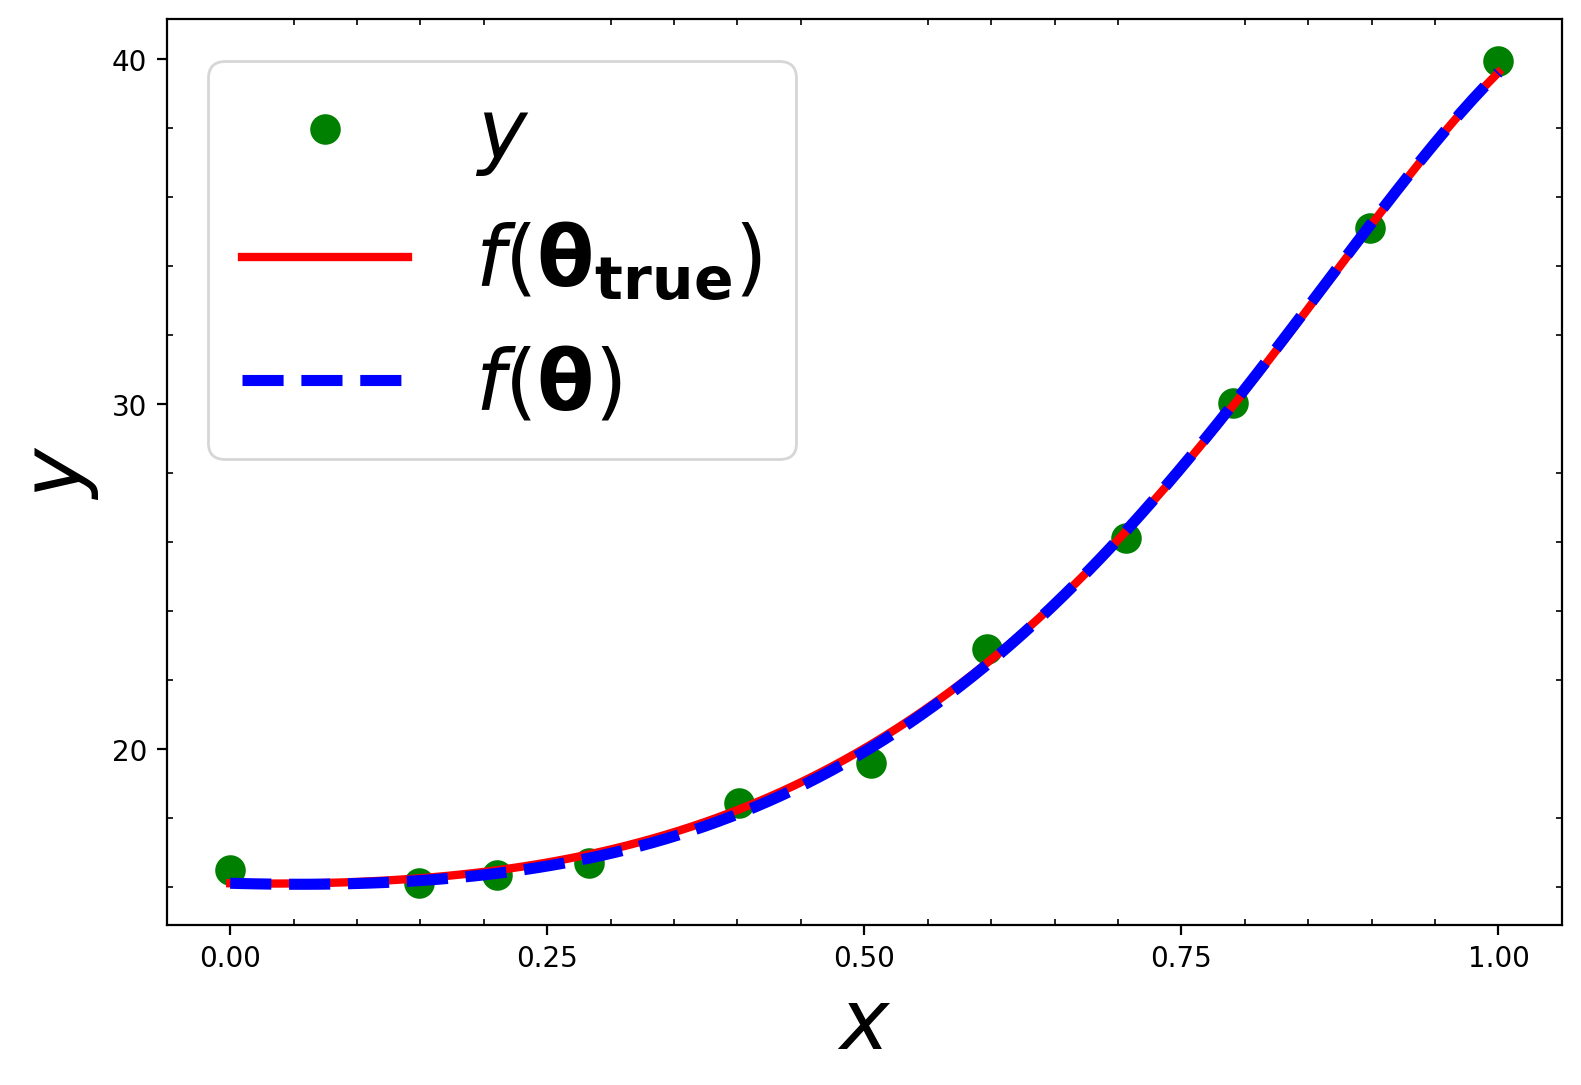

SSE =  0.8477473083263352


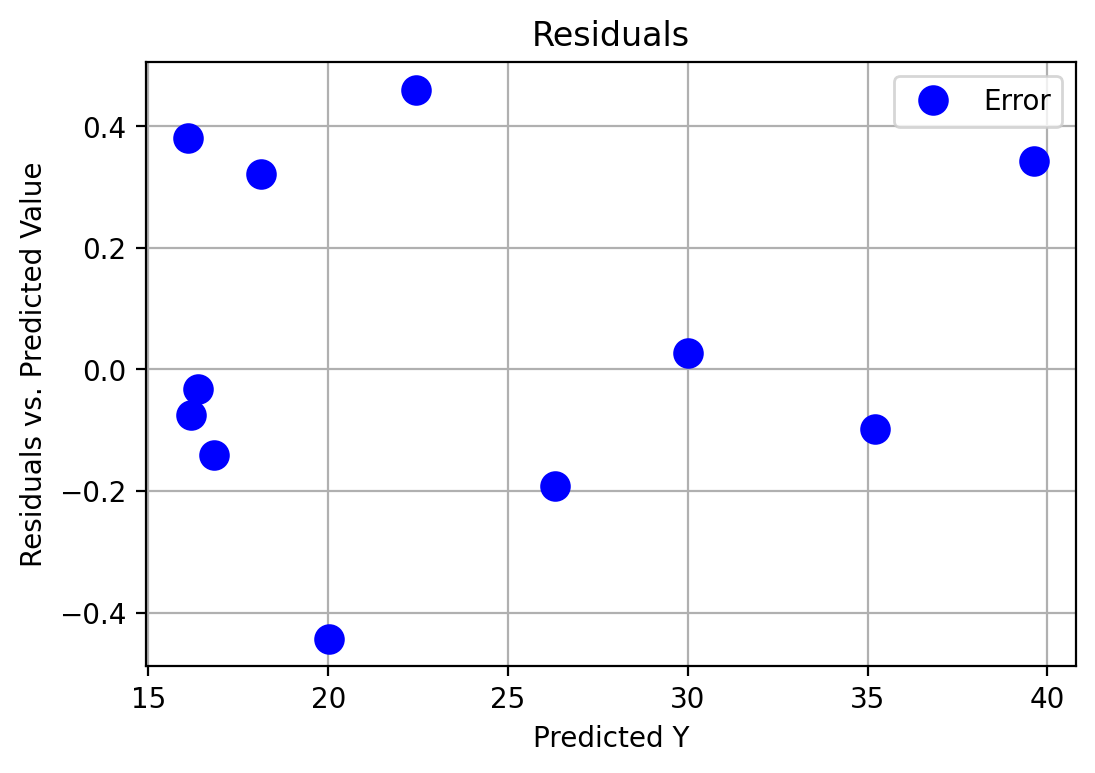

In [186]:
# create plot and compare predictions and experiments
X_pred = np.linspace(bounds_x[0][0], bounds_x[1][0],100).reshape(-1,1)
Y_pred = model(nlr_theta, theta_true, X_pred.reshape(-1,1), indeces_to_consider, argsvals)
print(Y_pred)
plt.figure(figsize = (9,6))
plt.plot(Xexp,Yexp,'.g',markersize=20,label=r'$y$')
plt.plot(X,Y,'r-',linewidth=3,label=r'$f(\mathbf{\theta_{true}})$')
plt.plot(X_pred,Y_pred,'--b',linewidth=4,label=r'$f(\mathbf{\theta})$')
# plt.title("Predictions with $\\theta = [0.994,-1.00]$ vs Synthetic Data")
# plt.title("Predictions with $\\theta = [0.802,-0.757]$ vs Synthetic Data")
plt.legend(loc = "best", fontsize=30) #(bbox_to_anchor=(1.04, 1), borderaxespad=0
plt.xlabel(r'$x$',fontsize=30,fontweight='bold')
plt.ylabel(r'$y$',fontsize=30,fontweight='bold')

plt.locator_params(axis='y', nbins=5)
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on() # turn on minor ticks
plt.tick_params(which="minor",direction="in",top=True, right=True)
# plt.grid(True)

# plt.savefig("Figures/sim_true_comp_poster.png", dpi=300, bbox_inches='tight')
plt.show()


##New Cell

#Plot error
print("SSE = ", np.sum(error**2))
plt.plot(Y_nlr_exp,error,"b.",markersize=20, label = "Error")
plt.title("Residuals")
plt.xlabel('Predicted Y')
plt.ylabel('Residuals vs. Predicted Value')
plt.grid(True)
plt.legend()
plt.show()


In [176]:
sigre = np.maximum(std**2, 0.01)
MSE = (error.T @ error)/(len(error) - 2)
Hess = Solution.jac.T @ Solution.jac
Covar = sigre * np.linalg.inv(Hess)
FIM = (1/sigre)*Hess
eigvals, eigvecs = np.linalg.eig(FIM)
k = np.max(eigvals)/np.min(eigvals)
print("MSE = ", MSE)
print("Experimental Variance = ", sigre)
print("Parameter Prediction Standard Deviation: \n", np.sqrt(np.diag(Covar)))
print("Covariance matrix:\n",Covar)
print("Det(FIM) = ", np.linalg.det(FIM))
print("Eigen Values (FIM):\n", eigvals)
print("Eigen Vectors (FIM)\n", eigvecs)
print("Condition Number (FIM): ", k)
print("Degree of precision loss (log10(k) of FIM): ", math.log10(k))

MSE =  0.000322781322424929
Experimental Variance =  0.01
Parameter Prediction Standard Deviation: 
 [5243.77365842 4792.44998703]
Covariance matrix:
 [[ 27497162.18077952 -25130384.77594439]
 [-25130384.7759444   22967576.8782194 ]]
Det(FIM) =  1.4394012982807005e-10
Eigen Values (FIM):
 [1.98158704e-08 7.26388128e-03]
Eigen Vectors (FIM)
 [[-0.73815917 -0.67462659]
 [ 0.67462659 -0.73815917]]
Condition Number (FIM):  366568.87313968845
Degree of precision loss (log10(k) of FIM):  5.564155584473443
